
<hr/>

# Introduction to Data Science
**Tamás Budavári** - budavari@jhu.edu <br/>

- Decision trees
- Cross-validation
- Random forests

<hr/>

<h1><font color="darkblue">Decision Tree</font></h1>

- Recursive partitioning of the training dataset

> At a given node with dataset $D$ we look for the
> best split 
> <br>
> <br>
> $\theta = $ (feature $j$, threshold $t$) 
> <br>
> <br>
> such that the 
> partitions $D_{\textrm{left}}(\theta)$ and $D_{\textrm{right}}(\theta)$ have minimal *impurity*
> <br>
> <br>
> $\displaystyle I(\theta) = \frac{n_{\textrm{left}}}{n}\, H\Big(D_{\textrm{left}}(\theta)\Big) + \frac{n_{\textrm{right}}}{n}\,H\Big(D_{\textrm{right}}(\theta)\Big)$

- Different impurity functions $H(\cdot)$

> E.g., Gini with $K$ classes in the partition $D$
> <br>
> <br>
>$\displaystyle H(D) = \sum_{i=1}^K p_i\, (1-p_i)$
> <br>
> <br>
> Or variance for regression


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,:2] # only first 2 features
c = iris.target
subset = (c<2) # classes 0 and 1
X,c = X[subset,:], c[subset]

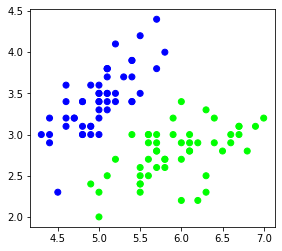

In [4]:
plt.subplot(111,aspect='equal'); 
plt.scatter(X[:,0],X[:,1],c=c,cmap=plt.cm.brg);

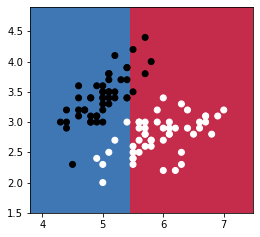

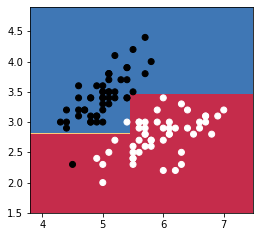

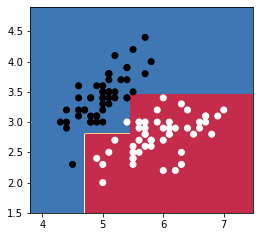

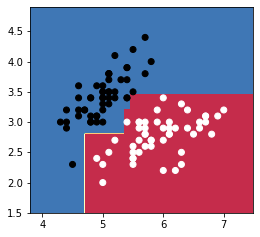

In [5]:
from sklearn import tree
# grid of points within the limits
h, d = 0.01, 0.5
x,y = np.meshgrid(np.arange(X[:,0].min()-d, X[:,0].max()+d, h),
                  np.arange(X[:,1].min()-d, X[:,1].max()+d, h))
grid = np.c_[x.ravel(),y.ravel()]

# decision-surfaces as fn of max depth
for depth in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    z = clf.fit(X,c).predict(grid).reshape(x.shape)
    plt.figure(figsize=(4,4)); plt.subplot(111,aspect='equal')
    plt.contourf(x, y, z, cmap=plt.cm.Spectral_r)
    plt.scatter(X[:,0], X[:,1], c=c, cmap=plt.cm.gray);

### Cross-validation

In [6]:
from sklearn.model_selection import cross_val_score

# quality as fn of max depth
for depth in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    s = cross_val_score(clf, X,c, cv=10) # apples to apples?
    print (depth, s.mean())

1 0.89
2 0.97
3 0.97
4 0.97


In [7]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, shuffle=True, random_state=42) 

scores = dict() # store the cv score of each split
for train, test in k_fold.split(X):
    for depth in range(1,5):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf.fit(X[train], c[train])
        score = clf.score(X[test], c[test])
        if depth not in scores: scores[depth] = [] # empty 
        scores[depth].append(score) # list for this depth

for depth in scores:
    s = np.array(scores[depth])
    print (depth, s.mean())

1 0.89
2 0.95
3 0.95
4 0.95


<h1><font color="darkblue">Random Forest</font></h1>

### Random Tree

- Hard to pick the *best* in high dimensions (i.e., very expensive)

> Instead we pick a number of random directions to search<br/>
> and take the optimal split among those

- A randomized tree will not be optimal but much faster to build

### Forest of Random Trees

- Create multiple randomized trees to classify

> Combine the results, e.g., voting

- Check out Boostrap and Bagging

array([1. , 1. , 1. , 1. , 1. , 1. , 0.9, 0.9, 0.9, 1. ])

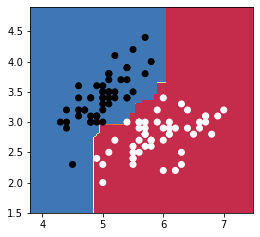

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=50,max_depth=2)
z = clf.fit(X,c).predict(grid).reshape(x.shape)

plt.figure(figsize=(4,4))
plt.subplot(1, 1, 1, aspect='equal')
plt.contourf(x, y, z, cmap=plt.cm.Spectral_r)
plt.scatter(X[:,0], X[:,1], c=c, cmap=plt.cm.gray);

cross_val_score(clf, X,c, cv=10)

### Assumptions and Limitations

- Axis parallel boundaries might be suboptimal

- But there is no need for a distance function

- And improved by random forest with many trees

also

- Improvements in the estimation error by random forest
cf. central limit theorem



### Feature Selection

- How frequently do we use a feature to split?

> It says something about how useful that feature is

In [10]:
clf.feature_importances_

array([0.49752263, 0.50247737])

### Divide and Conquer

- These methods are applicable to regression problems

> Minimize the variance of the left and right partitions
> <br>
> e.g., piecewise constant

- Useful concepts to consider to build complex methods



### Exercise

- What RF classifier gives the best result on the IRIS dataset?

> Vary the relevant parameters to find the best one!


In [11]:
# useful trick
[i*i for i in range(4)]

[0, 1, 4, 9]

In [12]:
# even conditionals
[(i, j, 4*i+j) for i in range(4) for j in range(4-i) if i*j>=2]

[(1, 2, 6), (2, 1, 9)]

In [13]:
# alias for short
RF = RandomForestClassifier

In [14]:
# labeled data
X = iris.data
c = iris.target

In [15]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42) 

# Create list of classifiers
clfs = [((n,d,f,c), RF(max_depth=d, n_estimators=n, max_features=f, criterion=c)) 
        for c in ['gini','entropy'] 
        for d in [2,3] 
        for n in [50,200] 
        for f in [2,3]]

print (len(clfs))

16


In [16]:
# Use k-fold CV to find the best
scores = dict() # store the cv score of each split
for train, test in k_fold.split(X):
    for param, clf in clfs:
        score = clf.fit(X[train],c[train]).score(X[test],c[test])
        if param not in scores: scores[param] = []
        scores[param].append(score)

In [17]:
for param in scores:
    print (param, np.mean(scores[param]))

(50, 2, 2, 'gini') 0.9533333333333335
(50, 2, 3, 'gini') 0.9466666666666667
(200, 2, 2, 'gini') 0.9533333333333334
(200, 2, 3, 'gini') 0.9466666666666667
(50, 3, 2, 'gini') 0.9600000000000002
(50, 3, 3, 'gini') 0.9600000000000002
(200, 3, 2, 'gini') 0.9600000000000002
(200, 3, 3, 'gini') 0.9600000000000002
(50, 2, 2, 'entropy') 0.9333333333333333
(50, 2, 3, 'entropy') 0.9466666666666667
(200, 2, 2, 'entropy') 0.9466666666666667
(200, 2, 3, 'entropy') 0.9400000000000001
(50, 3, 2, 'entropy') 0.9600000000000002
(50, 3, 3, 'entropy') 0.9600000000000002
(200, 3, 2, 'entropy') 0.9600000000000002
(200, 3, 3, 'entropy') 0.9600000000000002


### Automation: Pipeline and GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



### Unhomework

Go to http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html and modify the code to run all classifiers that we learned so far